## Lab3 Part 2

Lab3 is splitted into two parts as it is getting really long.
## Task 5.1 Dynamic Programming
The goal of this second half of the lab is to investigate dynamic progamming along scanlines in stereo vision.  In this part of the practical, we build a basic dynamic programming algorithm, which will solve the same problem as presented in the notes.  

In Task5 we will apply this to the stereo problem.  

Use the template below, filling in parts marked "TO DO" (only todo for Task 5.1 one is in functions.py).



In [261]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from functions import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
# Defining the unary and pairwise costs for the dynamic programming algorithm for 6 pixels and 5 disparity levels.

# Define unary costs unaryCosts[d,j] 
# represents the cost for having disparity d (rows) at pixel j (columns).
unaryCosts = np.array([ [2.0, 1.1, 5.7, 1.5, 6.0, 3.1],
                        [0.8, 4.8, 1.0, 3.0, 6.9, 3.3],
                        [4.3, 2.3, 2.4, 2.4, 6.6, 6.2],
                        [6.4, 0.0, 6.1, 0.8, 7.1, 2.1],
                        [2.3, 2.2, 4.9, 8.9, 1.0, 9.8]])
nY = len(unaryCosts) # Number of pixels
nX = len(unaryCosts[0]) # Number of disparity levels

# Define pairwise costs:  pairwiseCosts[a,b] 
# represents the cost for changing from disparity level a to disparity level b.
# The matrix is symmetric, i.e., pairwiseCosts[a,b] = pairwiseCosts[b,a]
# suggesting that the cost of changing from a to b is the same as from b to a.
pairwiseCosts = np.array([[   0,   2, 100, 100, 100],
                          [   2,   0,   2, 100, 100],
                          [ 100,   2,   0,   2, 100],
                          [ 100, 100,   2,   0,   2],
                          [ 100, 100, 100,   2,   0]])


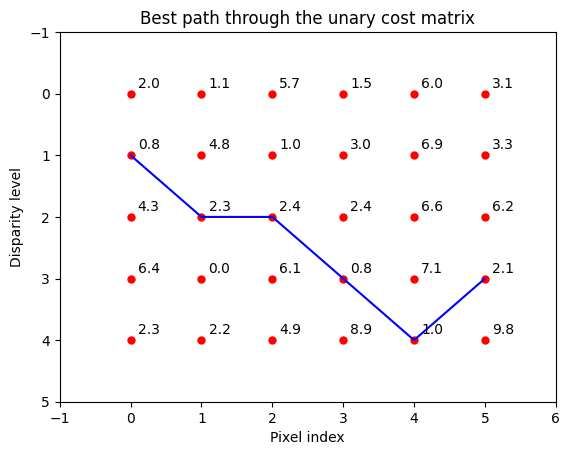

Path Cost = 17.4


In [ ]:
## Use the dynamic programming algorithm to find the best path
bestPath = dynamicProgram(unaryCosts,pairwiseCosts)

## Calculate the cost of the best path: equal to the sum of unary and pairwise costs along the best path
# Sum of unary costs along the best path
bestPathCostUnary = np.sum((np.transpose(unaryCosts).reshape((nX*nY,1)))[(np.add(nY * np.array(range(nX)),np.transpose(bestPath)[0])).astype(int)])
# Sum of pairwise costs along the best path
bestPathCostPairwise = np.sum(np.transpose(pairwiseCosts).reshape((nY*nY,1))[np.array([bestPath[0:-1]+nY*bestPath[1:]]).reshape((1,nY)).astype(int)[0]])
# Total cost
bestCost = bestPathCostUnary + bestPathCostPairwise
# Display the cost of the best path


## Display the best path results
plt.figure()
plt.axis([-1, 6, 5, -1]) # Note that the y axis was reversed to match the matrix elements
for cY in range(nY):
    for cX in range(nX):
        plt.plot(cX,cY,'ro',ms=5.)
        plt.text(cX+.1, cY-.1, unaryCosts[cY,cX])

# Display the best path
plt.plot(range(nX),bestPath,'b-')
plt.title('Best path through the unary cost matrix')
plt.xlabel('Pixel index')
plt.ylabel('Disparity level')
# Save figure
figName = f'../results/lab3/lowestCostPath.png'
plt.savefig(figName)
plt.show()
print('Path Cost =',bestCost)


## Task 5.2 Dynamic Programming for stereo depth estimation


The goal of this part of the practical is to use the dynamic programming routine that you developed in the first part to solve the dense stereo problem.

Use the template below, filling in parts marked "TO DO".

### Extra Tasks:
Task hint: Crop or downsample your image if your stereo is slow

Task1: Capture or find two image pairs: one with good stereo depth and one with bad stereo depth. Note that you should only the two camera have a known, and there should be no moving objects in the scene.

Task2: Measure your baseline distance between the camera with a ruler, does the depth esimation match the real distance？

Task3: (Unmarked Optional) Can you use two cameras at the same time for stereo capture?

In [131]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from functions import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


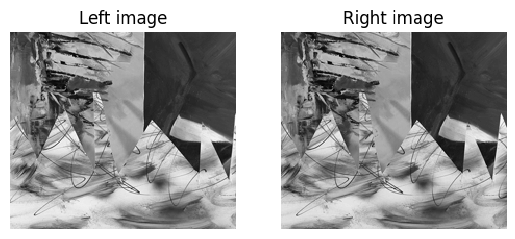

In [312]:
# load in images and ground truth
data = loadmat('../dataset/StereoData.mat')
imr = data['im1'].astype('int') 
iml = data['im2'].astype('int')
gt = data['gt'].astype('int')

# Ground truth disparity is originally expressed in 16'ths of pixels 
# but we will only consider whole-pixel shifts
gtDisp = np.round(gt.astype(float)/16)
# Normalise images for display [0-255] --> [0-1]
imr_show = imr 
iml_show = iml 
if np.max(imr) > 1:
    imr_show = imr.astype(float)/255. 
    iml_show = iml.astype(float)/255.
    
# Plot images and ground truth disparity
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(iml_show, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax1.set_title('Left image')

ax2.imshow(imr_show, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
ax2.set_title('Right image')
figName = f'../results/lab3/stereoImages.png'
plt.savefig(figName)
plt.show()

### Complete the TODOs in the final cell below

Here we are going to make use of the "dynamicProgram" function we just wrote.

We will first calculate the unary costs before using our function to calculate estimated disparity.

Image shape: 190x217
Procesing scanline  190  of  190
Max Disp: 10
imX - maxDisp: 207


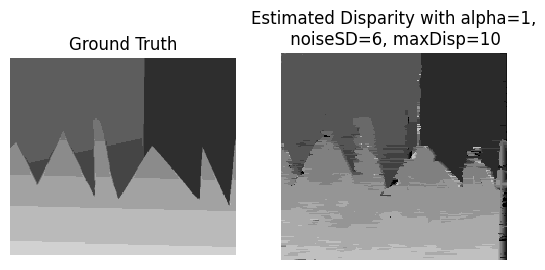

In [317]:
# Shape of the images
imY = imr.shape[0] # Rows in the image
imX = imr.shape[1] # Columns in the image
print(f'Image shape: {imY}x{imX}')

# Define the maximum dispaity W: i.e. the number of pixels we will search for a match
maxDisp = 10 # Maximum disparity considered in the search
# Define standard deviation of noise in the images
noiseSD = 6 
# Define the pairwise costs
# Zero cost for staying the same (diagonal elements) and fixed cost alpha for changing disparity (elsewhere)
alpha = 1
pairwiseCosts = alpha * (np.ones([maxDisp,maxDisp]) - np.eye(maxDisp)) # Shape of maxDisp x maxDisp

# Initialise the estimated disparity map
# Limit the size of the disparity map to avoid going out of bounds
estDisp = np.zeros([imY,imX-maxDisp]) 

# Run through each scanline
for cY in range(imY): 

    # Define unary costs 
    unaryCosts = np.zeros([maxDisp,imX-maxDisp]) # Shape of maxDisp x (imX-maxDisp)

    for cDisp in range(maxDisp): # For each disparity level (column in the disparity map)
        cost=np.zeros(imX-maxDisp) # Cost holder for each pixel in the scanline
        for cX in range(imX-maxDisp): # For each pixel in the scanline
            # Ensure valid bounds for slices
            imr_slice = imr[cY, cX:cX+maxDisp] # cX+maxDisp is the end of the slice
            # cDisp : diparity currently being considered
            # cX+cDisp : start of the slice in the left image
            # cX+cDisp+maxDisp : end of the slice in the left image (limited with the image width imX)
            iml_slice = iml[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)]
            # Pad iml_slice with zeros if it is shorter than maxDisp
            if len(iml_slice) < maxDisp:
                iml_slice = np.pad(iml_slice, (0, maxDisp - len(iml_slice)), mode='constant', constant_values=0)
            
            # Calculate the difference between the two slices
            diff = imr_slice - iml_slice
            diff2 = np.square(diff)
            
            # Calculate the cost as the sum of squared differences
            # divided by the noise standard deviation to normalise the cost
            cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
            
        
        # Store the cost in the unaryCosts matrix as a row
        unaryCosts[cDisp,:] = cost

            
    # Run dynamic programming algorithm to find the best path for each scanline
    estDisp[cY,:] = np.transpose(dynamicProgram(unaryCosts,pairwiseCosts))

print('Procesing scanline ',cY + 1, ' of ', imY)
print(f'Max Disp: {maxDisp}')
print(f'imX - maxDisp: {imX-maxDisp}')
# display solution so far
f, (ax1, ax2) = plt.subplots(1, 2)
#ax1.clear()
ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
ax1.axis('off')
ax1.set_title('Ground Truth')
#ax2.clear()
ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
ax2.axis('off')
ax2.set_title(f'Estimated Disparity with alpha={alpha},\n noiseSD={noiseSD}, maxDisp={maxDisp}')

# Save figure
figName = f'../results/lab3/EstimatedDisparity_with_alpha{alpha}_noiseSD{noiseSD}_and_maxDisp{maxDisp}.png'
plt.savefig(figName)
plt.show()
    

Image shape: 190x217
Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


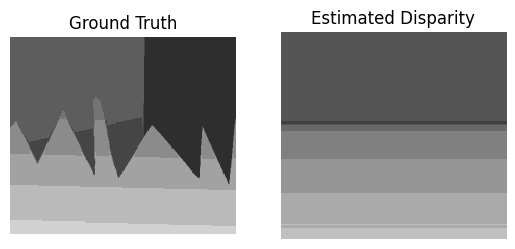

In [308]:
# Use victorisation to speed up the process
# Shape of the images
imY = imr.shape[0] # Rows in the image
imX = imr.shape[1] # Columns in the image
print(f'Image shape: {imY}x{imX}')

# Define the maximum dispaity W: i.e. the number of pixels we will search for a match
maxDisp = 10 # Maximum disparity considered in the search
# Define standard deviation of noise in the images
noiseSD = 6 
# Define the pairwise costs
# Zero cost for staying the same (diagonal elements) and fixed cost alpha for changing disparity (elsewhere)
alpha = 1
pairwiseCosts = alpha * (np.ones([maxDisp,maxDisp]) - np.eye(maxDisp)) # Shape of maxDisp x maxDisp

# Initialise the estimated disparity map
# Limit the size of the disparity map to avoid going out of bounds
estDisp = np.zeros([imY,imX-maxDisp]) 

# Run through each scanline
for cY in range(imY): 
    # Define unary costs 
    unaryCosts = np.zeros([maxDisp,imX-maxDisp]) # Shape of maxDisp x (imX-maxDisp)
    for cDisp in range(maxDisp):  # For each disparity level (column in the disparity map)
        # Generate slices for imr and iml in one go using NumPy slicing
        imr_slices = imr[cY, :imX-maxDisp]  # imr stays fixed for each cDisp
        iml_slices = np.zeros_like(imr_slices)  # Initialize with zeros to handle padding
        
        # Compute iml_slices considering disparity and ensure proper bounds
        start_idx = cDisp
        end_idx = cDisp + (imX - maxDisp)
        iml_slices[:min(end_idx, imX-maxDisp)] = iml[cY, start_idx:end_idx]
        
        # Calculate the difference and cost in a vectorized way
        diff = imr_slices - iml_slices
        diff2 = np.square(diff)
        cost = np.sum(diff2) / (2 * noiseSD**2)
        
        # Store the computed cost in unaryCosts matrix
        unaryCosts[cDisp, :] = cost

        # Run dynamic programming algorithm to find the best path for each scanline
        estDisp[cY,:] = np.transpose(dynamicProgramVec(unaryCosts,pairwiseCosts))

print('Procesing scanline ',cY)
print(f'Max Disp: {maxDisp}')
print(f'imX - maxDisp: {imX-maxDisp}')
# display solution so far
f, (ax1, ax2) = plt.subplots(1, 2)
#ax1.clear()
ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
ax1.axis('off')
ax1.set_title('Ground Truth')
#ax2.clear()
ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
ax2.axis('off')
ax2.set_title('Estimated Disparity')
plt.show()

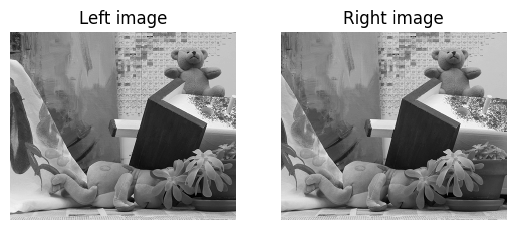

In [377]:
import cv2 as cv
# Import stero images and ground truth disparity
imr = cv.imread("../dataset/teddy/im1.png", cv.IMREAD_GRAYSCALE)
iml = cv.imread("../dataset/teddy/im2.png", cv.IMREAD_GRAYSCALE)
gtr = cv.imread("../dataset/teddy/disp1.png", cv.IMREAD_GRAYSCALE)
gtl = cv.imread("../dataset/teddy/disp2.png", cv.IMREAD_GRAYSCALE)

# # Down sample images
imr = cv.resize(imr, (0,0), fx=0.5, fy=0.5)
iml = cv.resize(iml, (0,0), fx=0.5, fy=0.5)

# Plot images and ground truth disparity
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(iml, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax1.set_title('Left image')
ax2.imshow(imr, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
ax2.set_title('Right image')
figName = f'../results/lab3/stereoImages2.png'
plt.savefig(figName)
plt.show()


Image shape: 375x450
Procesing scanline  374
Max Disp: 50
imX - maxDisp: 400


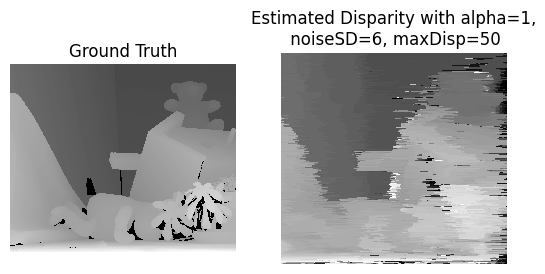

In [ ]:
# Shape of the images
imY = imr.shape[0] # Rows in the image
imX = imr.shape[1] # Columns in the image
print(f'Image shape: {imY}x{imX}')
# Define the maximum disparity to consider
maxDisp = 25

# Define standard deviation of noise
noiseSD = 6 # standard deviation of noise

# Define the pairwise costs
# Zero cost for staying the same (diagonal elements) and fixed cost alpha for changing disparity (elsewhere)
alpha = 1
pairwiseCosts = alpha * (np.ones([maxDisp,maxDisp]) - np.eye(maxDisp))

# Initialise the estimated disparity map

estDisp = np.zeros([imY,imX-maxDisp]) 

# Run through each scanline
for cY in range(imY):
    
    # Define unary costs 
    # we will not use the last few columns of the image 
    # as the disparity might map the pixel outside the valid area of the second image
    unaryCosts = np.zeros([maxDisp,imX-maxDisp])

    for cDisp in range(maxDisp):
        cost=np.zeros(imX-maxDisp) # Cost for this disparity level

        for cX in range(imX-maxDisp):
            # Ensure valid bounds for slices
            imr_slice = imr[cY, cX:cX+maxDisp]
            iml_slice = iml[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)] # Ensure we don't go out of bounds
            
            # Pad im2_slice if it's smaller than maxDisp
            if len(iml_slice) < maxDisp:
                iml_slice = np.pad(iml_slice, (0, maxDisp - len(iml_slice)), mode='constant', constant_values=0)
            
            # Calculate the difference between the two slices
            diff = imr_slice - iml_slice
            diff2 = np.square(diff)
            
            # Calculate the cost
            cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
            
        
        # Store the cost in the unaryCosts matrix as a row
        unaryCosts[cDisp,:] = cost

            
    # Run dynamic programming algorithm to find the best path for each scanline
    estDisp[cY,:] = np.transpose(dynamicProgramVec(unaryCosts,pairwiseCosts))

print('Procesing scanline ',cY)
print(f'Max Disp: {maxDisp}')
print(f'imX - maxDisp: {imX-maxDisp}')
# display solution so far
f, (ax1, ax2) = plt.subplots(1, 2)
#ax1.clear()
ax1.imshow(gtr, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax1.set_title('Ground Truth')
#ax2.clear()
ax2.imshow(estDisp, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
ax2.axis('off')
ax2.set_title(f'Estimated Disparity with alpha={alpha},\n noiseSD={noiseSD}, maxDisp={maxDisp}')

# Save figure
figName = f'../results/lab3/EstimatedDisparity2_with_alpha{alpha}_noiseSD{noiseSD}_and_maxDisp{maxDisp}.png'
plt.savefig(figName)
plt.show()



In [ ]:
import cv2 as cv
# Import stero images and ground truth disparity
imr = cv.imread("../dataset/testOwn2/im1.png", cv.IMREAD_GRAYSCALE)
iml = cv.imread("../dataset/testOwn2/im2.png", cv.IMREAD_GRAYSCALE)

# Shape of the images
imY = imr.shape[0] # Rows in the image
imX = imr.shape[1] # Columns in the image

print(f'Image shape before downsampling: {imY}x{imX}')

imr = cv.resize(imr, (400, 500), interpolation=cv.INTER_LINEAR)
iml = cv.resize(iml, (400, 500), interpolation=cv.INTER_LINEAR)
imY = imr.shape[0] # Rows in the image
imX = imr.shape[1] # Columns in the image
print(f'Image shape after downsampling: {imY}x{imX}')

Image shape before downsampling: 5712x4284
Image shape after downsampling: 500x400


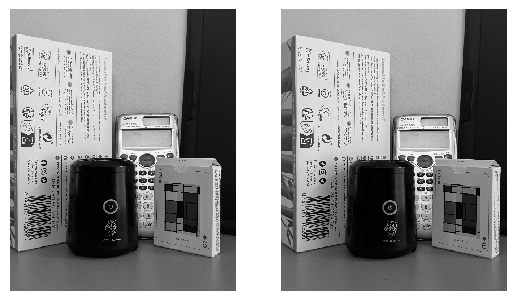

In [ ]:
# Display images
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imr, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax2.imshow(iml, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
plt.show()

Procesing scanline  499
Max Disp: 30
imX - maxDisp: 370


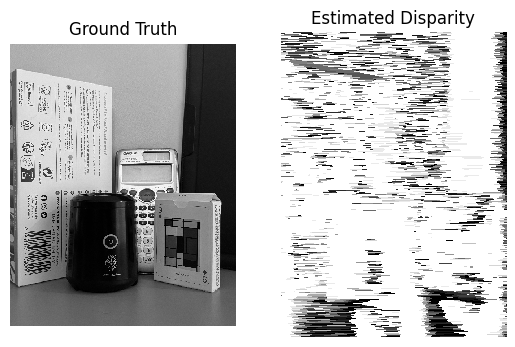

In [ ]:
# Define the maximum disparity to consider
maxDisp = 30

# Define standard deviation of noise
noiseSD = 10 # standard deviation of noise

# Define the pairwise costs
# Zero cost for staying the same (diagonal elements) and fixed cost alpha for changing disparity (elsewhere)
alpha = 1
pairwiseCosts = alpha * (np.ones([maxDisp,maxDisp]) - np.eye(maxDisp))

# Initialise the estimated disparity map

estDisp = np.zeros([imY,imX-maxDisp]) 

# Run through each scanline
for cY in range(imY):
    
    # Define unary costs 
    # we will not use the last few columns of the image 
    # as the disparity might map the pixel outside the valid area of the second image
    unaryCosts = np.zeros([maxDisp,imX-maxDisp])

    for cDisp in range(maxDisp):
        cost=np.zeros(imX-maxDisp) # Cost for this disparity level

        for cX in range(imX-maxDisp):
            # Ensure valid bounds for slices
            imr_slice = imr[cY, cX:cX+maxDisp]
            iml_slice = iml[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)] # Ensure we don't go out of bounds
            
            # Pad im2_slice if it's smaller than maxDisp
            if len(iml_slice) < maxDisp:
                iml_slice = np.pad(iml_slice, (0, maxDisp - len(iml_slice)), mode='constant', constant_values=0)
            
            # Calculate the difference between the two slices
            diff = imr_slice - iml_slice
            diff2 = np.square(diff)
            
            # Calculate the cost
            cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
            
        
        # Store the cost in the unaryCosts matrix as a row
        unaryCosts[cDisp,:] = cost

            
    # Run dynamic programming algorithm to find the best path for each scanline
    estDisp[cY,:] = np.transpose(dynamicProgramVec(unaryCosts,pairwiseCosts))

print('Procesing scanline ',cY)
print(f'Max Disp: {maxDisp}')
print(f'imX - maxDisp: {imX-maxDisp}')
# display solution so far
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imr, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax1.set_title('Ground Truth')
#ax2.clear()
ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
ax2.axis('off')
ax2.set_title('Estimated Disparity')
plt.show()

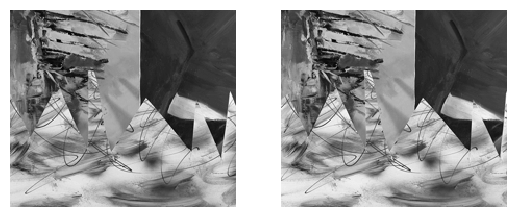

Processing noiseSD = 1
Processing noiseSD = 10
Processing noiseSD = 20
Processing noiseSD = 40
Processing noiseSD = 80


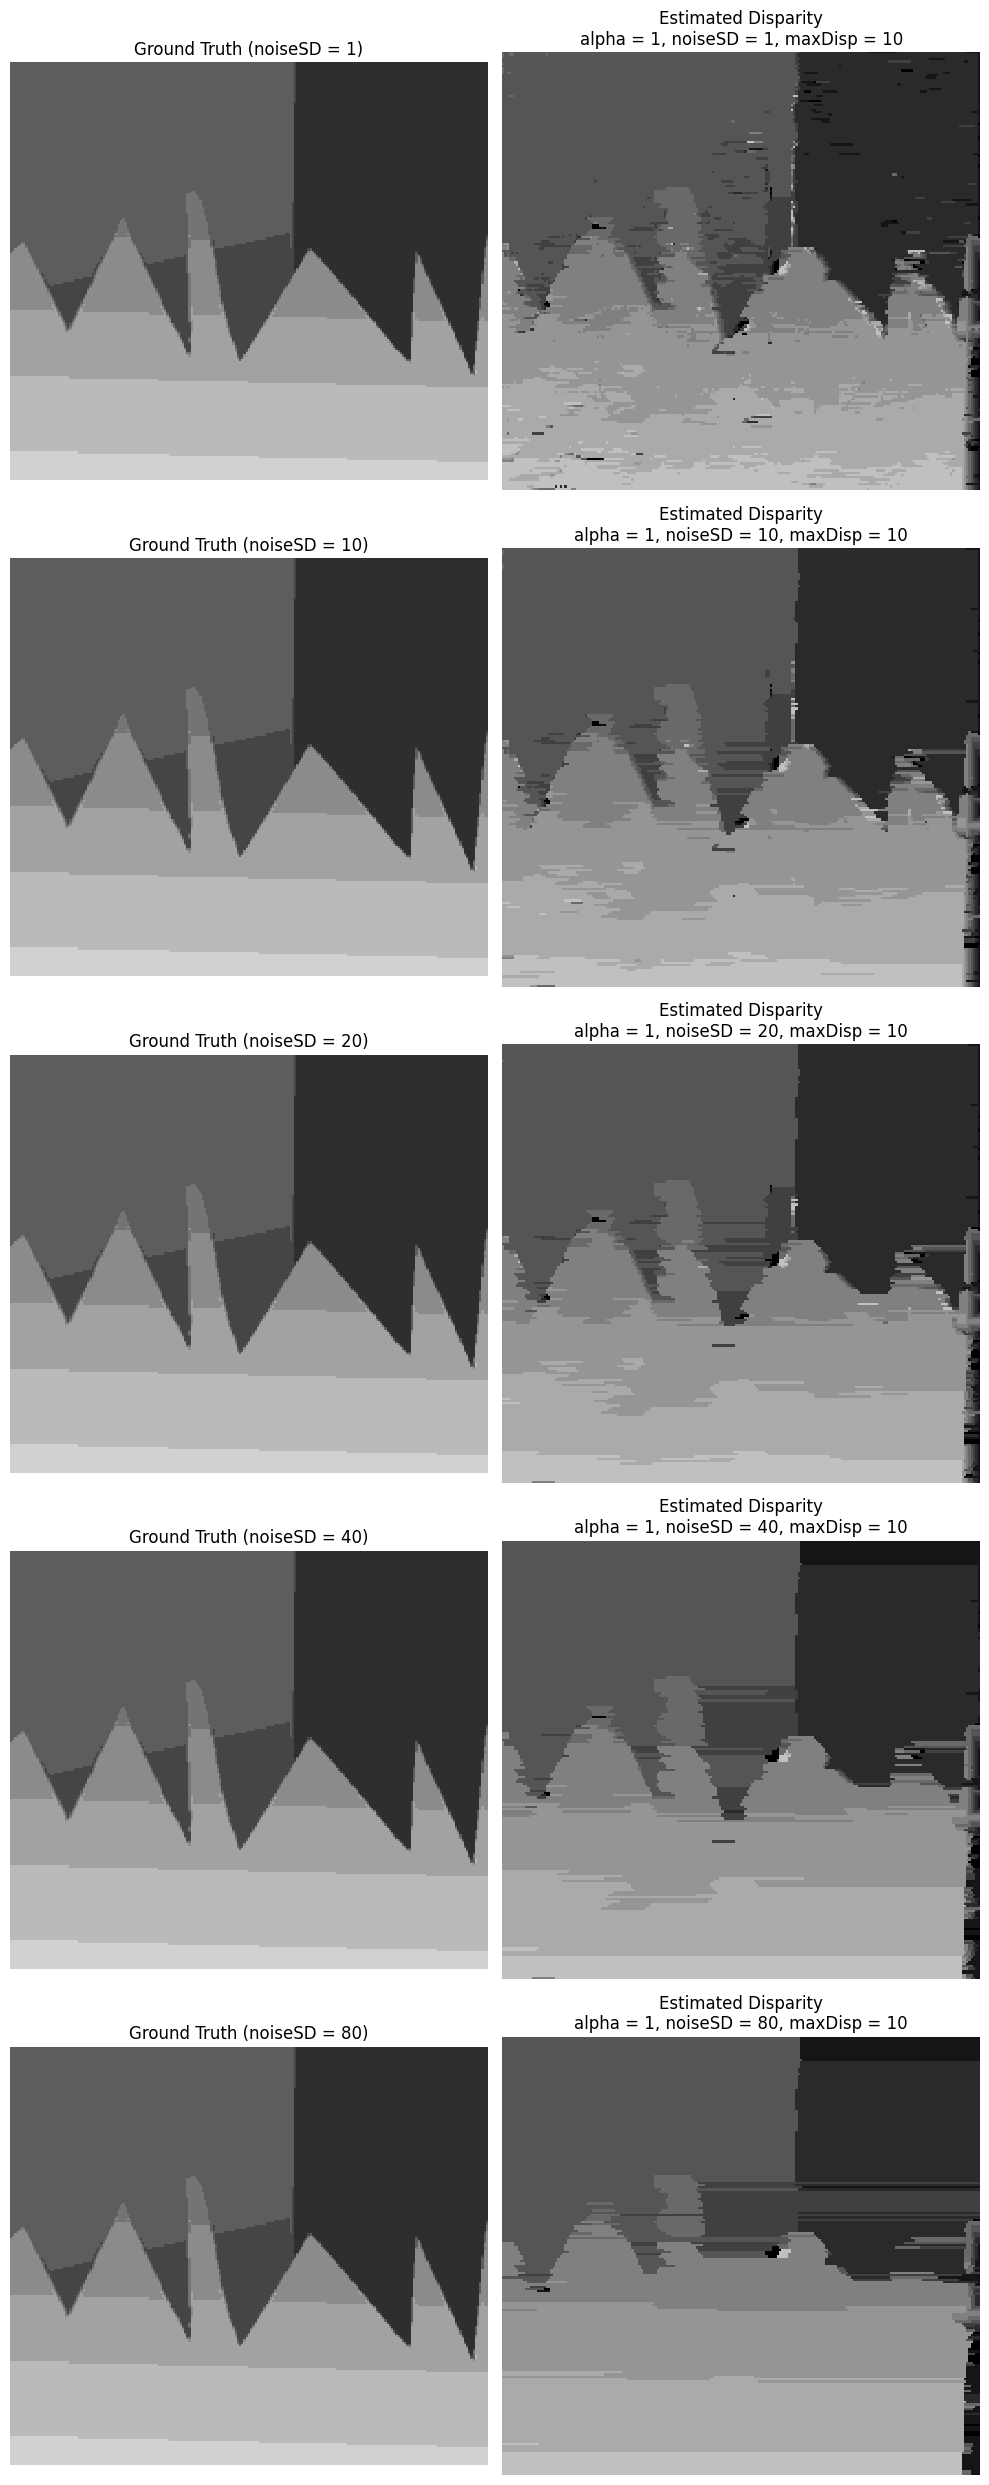

Processing alpha = 1
Processing alpha = 10
Processing alpha = 100
Processing alpha = 1000


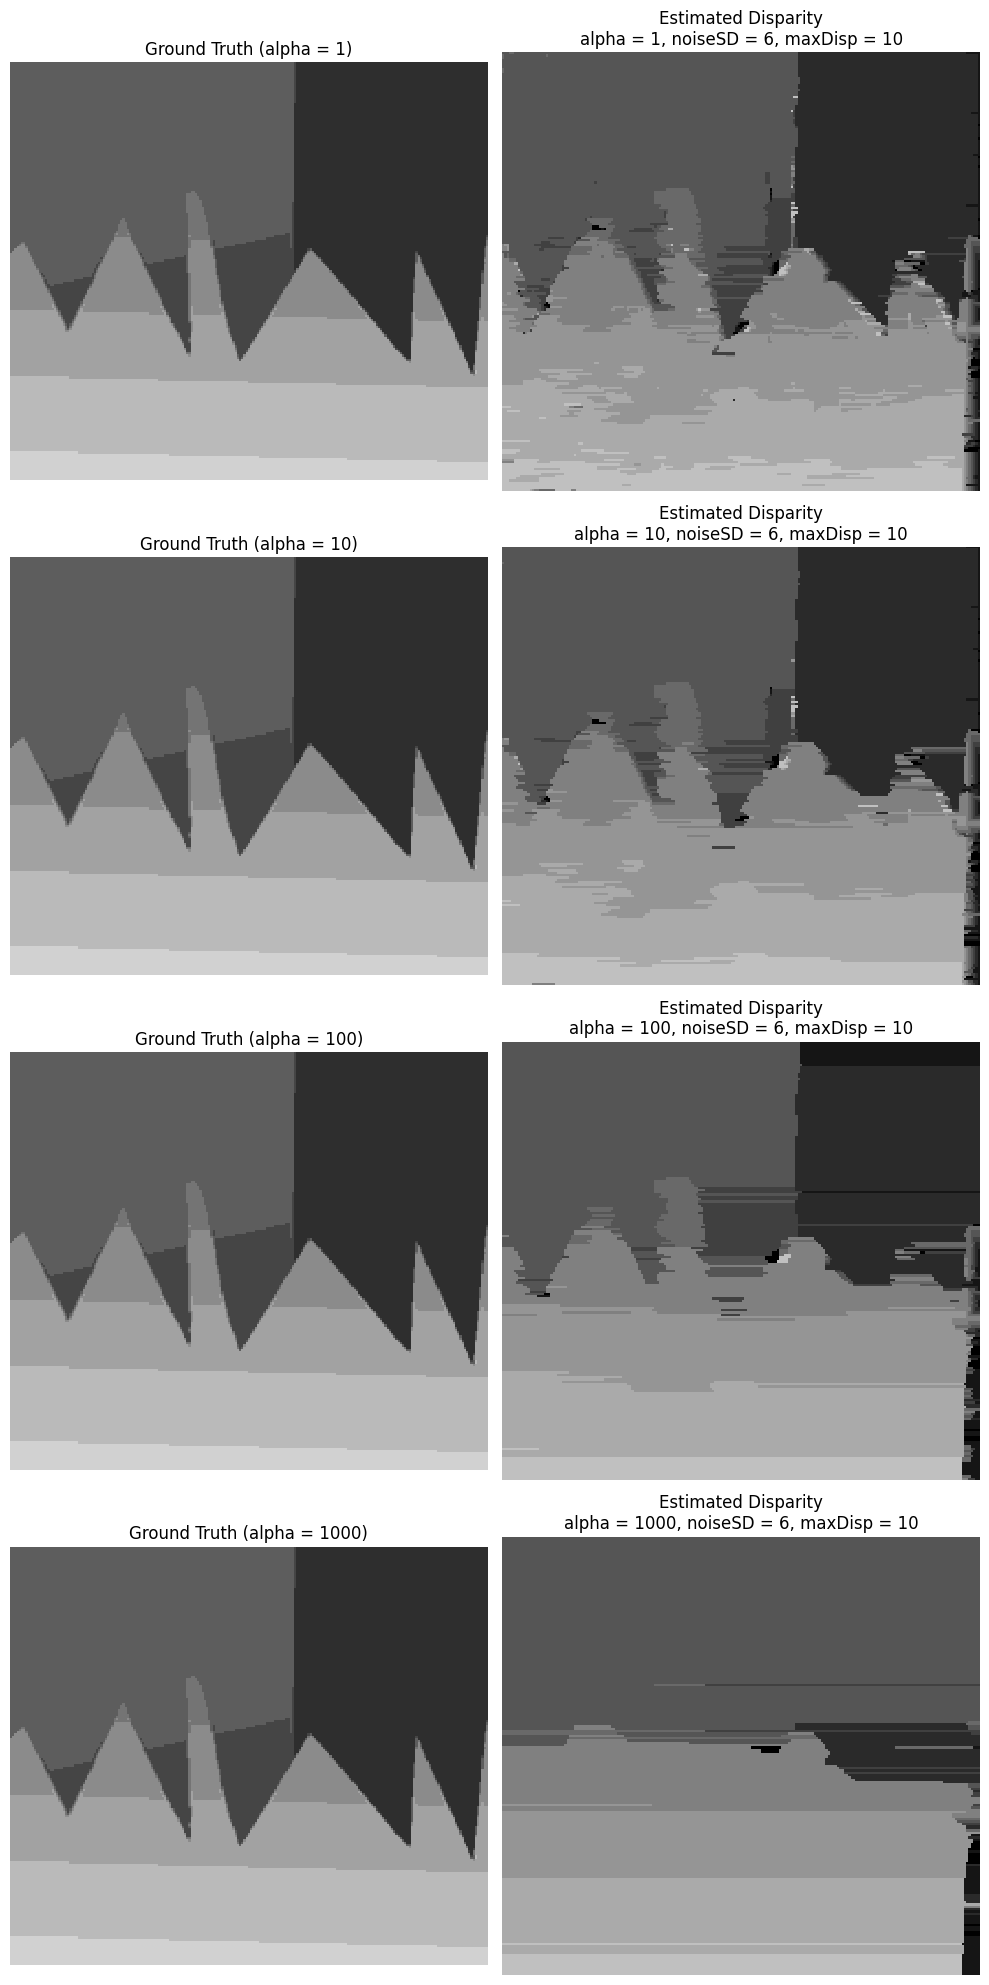

Processing maxDisp = 5
Processing maxDisp = 10
Processing maxDisp = 20
Processing maxDisp = 30


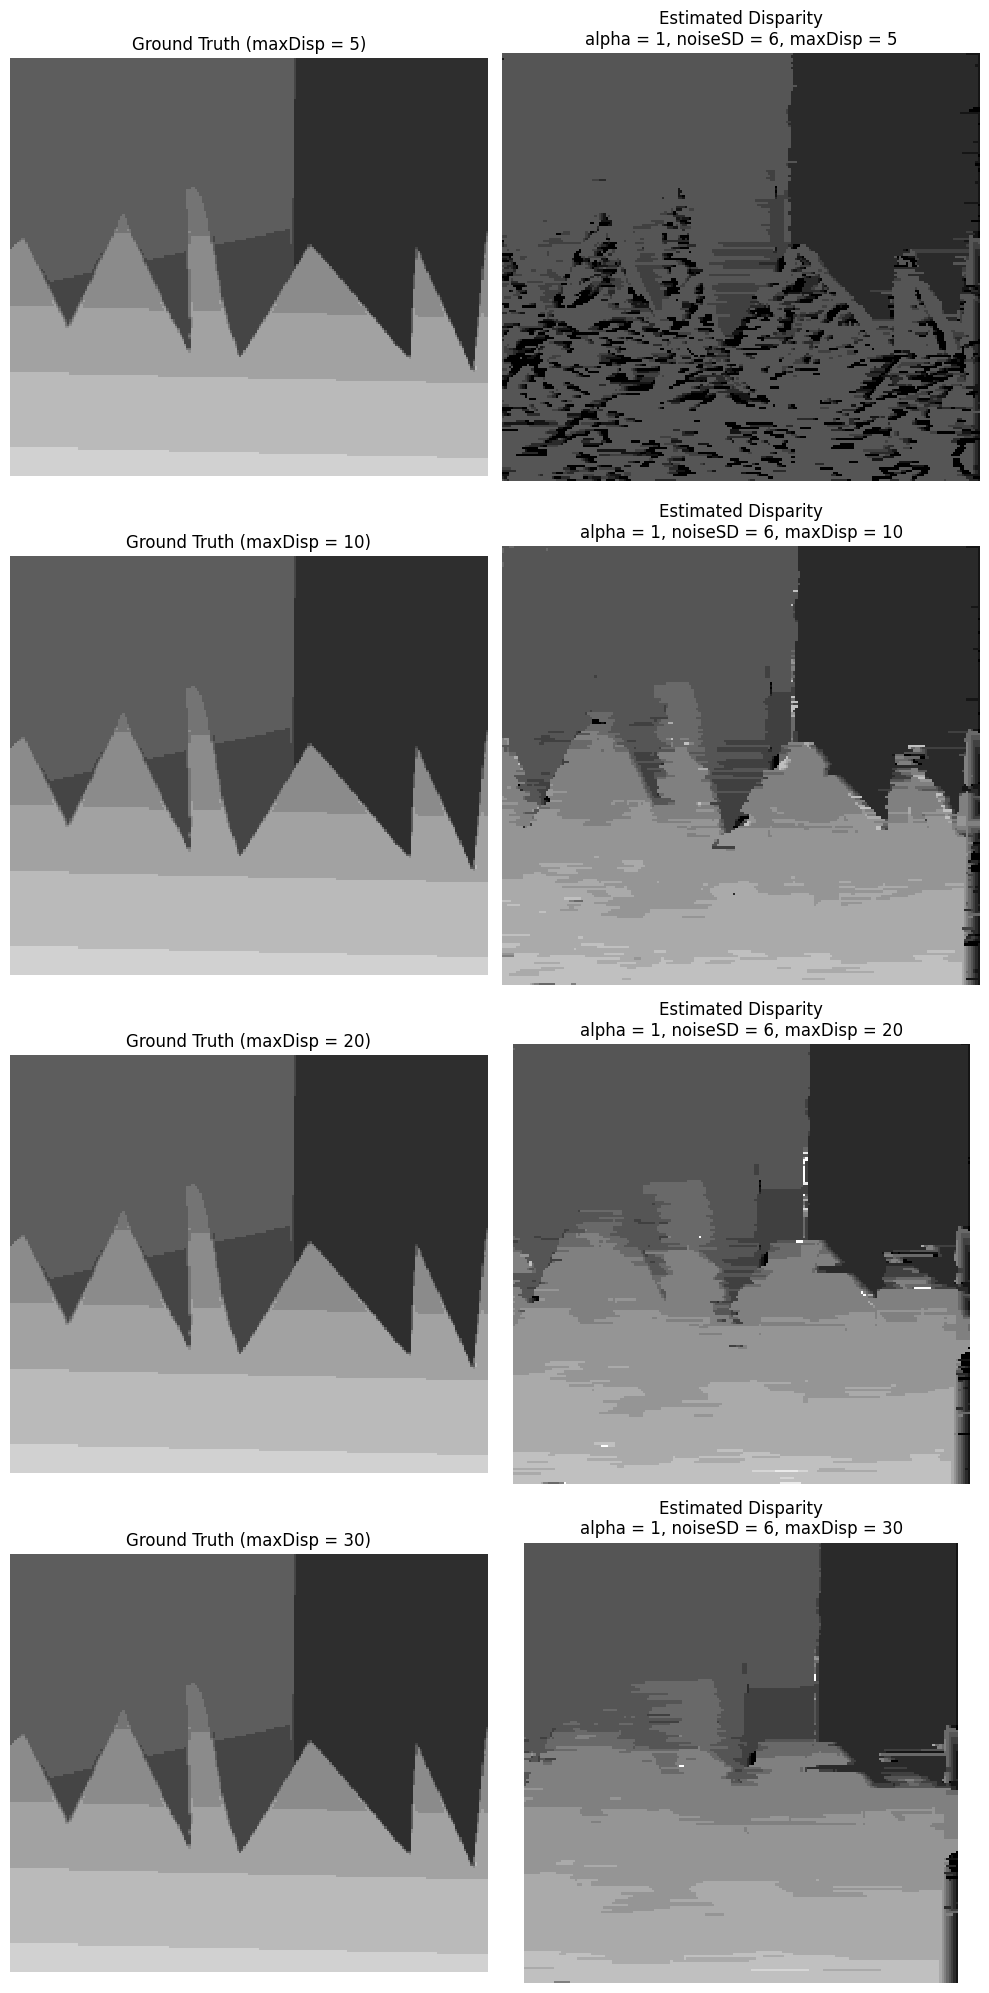

In [ ]:
# load in images and ground truth
data = loadmat('../dataset/StereoData.mat')
imr = data['im1'].astype('int') 
iml = data['im2'].astype('int')
gt = data['gt'].astype('int')

# Ground truth disparity is originally expressed in 16'ths of pixels 
# but we will only consider whole-pixel shifts
gtDisp = np.round(gt.astype(float)/16)
# Normalise images for display [0-255] --> [0-1]
imr_show = imr 
iml_show = iml 
if np.max(imr) > 1:
    imr_show = imr.astype(float)/255. 
    iml_show = iml.astype(float)/255.

# Plot images and ground truth disparity
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imr_show, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax2.imshow(iml_show, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
plt.show()

# TODO - investigate how different values of alpha and noiseSD affect the results
maxDisp_array = np.array([5, 10, 20, 30]) # maximum disparity
noiseSD_array = np.array([1, 10, 20, 40, 80]) # standard deviation of noise
alpha_array= np.array([1, 10, 100, 1000]) # alpha

imY = imr.shape[0] # Rows in the image
imX = imr.shape[1] # Columns in the image


maxDisp = 10

################## Iterating through noiseSD values ##################
alpha = 1
pairwiseCosts = alpha * (np.ones([maxDisp,maxDisp]) - np.eye(maxDisp))
estDisp = np.zeros([imY,imX-maxDisp]) 
# Initialize a figure to collect subplots
num_noise_levels = len(noiseSD_array)
fig, axes = plt.subplots(num_noise_levels, 2, figsize=(10, 5 * num_noise_levels))

for idx, noiseSD in enumerate(noiseSD_array):
    # Run through each scanline
    for cY in range(imY):
        # Define unary costs
        unaryCosts = np.zeros([maxDisp, imX - maxDisp])

        for cDisp in range(maxDisp):
            cost = np.zeros(imX - maxDisp)  # Cost for this disparity level

            for cX in range(imX - maxDisp):
                # Ensure valid bounds for slices
                imr_slice = imr[cY, cX:cX+maxDisp]
                iml_slice = iml[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)]
                
                # Pad iml_slice if it's smaller than maxDisp
                if len(iml_slice) < maxDisp:
                    iml_slice = np.pad(iml_slice, (0, maxDisp - len(iml_slice)), mode='constant', constant_values=0)
                
                # Calculate the difference between the two slices
                diff = imr_slice - iml_slice
                diff2 = np.square(diff)
                
                # Calculate the cost
                cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
            
            # Store the cost in the unaryCosts matrix as a row
            unaryCosts[cDisp, :] = cost

        # Run dynamic programming algorithm to find the best path for each scanline
        estDisp[cY, :] = np.transpose(dynamicProgramVec(unaryCosts, pairwiseCosts))

    # Add subplots for the current noiseSD
    print(f'Processing noiseSD = {noiseSD}')
    axes[idx, 0].imshow(gtDisp, vmin=0, vmax=11, cmap='gray', extent=[0, len(gtDisp[0]), 0, len(gtDisp)], interpolation='nearest')
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title(f'Ground Truth (noiseSD = {noiseSD})')

    axes[idx, 1].imshow(estDisp, vmin=0, vmax=12, cmap='gray', extent=[0, len(estDisp[0]), 0, len(estDisp)], interpolation='nearest')
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title(f'Estimated Disparity\nalpha = {alpha}, noiseSD = {noiseSD}, maxDisp = {maxDisp}')

# Save the combined figure after the loop ends
figName = f'../results/lab3/Combined_EstimatedDisparity_varyingAlpha.png'
plt.tight_layout()
plt.savefig(figName)
plt.show()


################## Iterating through alpha values ##################
# Set noiseSD to 6 and iterate through alpha
noiseSD = 6
num_alpha_values = len(alpha_array)
# Initialize a figure for the combined plot
fig, axes = plt.subplots(num_alpha_values, 2, figsize=(10, 5 * num_alpha_values))

for idx, alpha in enumerate(alpha_array):
    # Compute pairwise costs
    pairwiseCosts = alpha * (np.ones([maxDisp, maxDisp]) - np.eye(maxDisp))
    estDisp = np.zeros([imY, imX - maxDisp])

    for cY in range(imY):
        # Define unary costs
        unaryCosts = np.zeros([maxDisp, imX - maxDisp])

        for cDisp in range(maxDisp):
            cost = np.zeros(imX - maxDisp)  # Cost for this disparity level

            for cX in range(imX - maxDisp):
                # Ensure valid bounds for slices
                imr_slice = imr[cY, cX:cX+maxDisp]
                iml_slice = iml[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)]
                
                # Pad iml_slice if it's smaller than maxDisp
                if len(iml_slice) < maxDisp:
                    iml_slice = np.pad(iml_slice, (0, maxDisp - len(iml_slice)), mode='constant', constant_values=0)
                
                # Calculate the difference between the two slices
                diff = imr_slice - iml_slice
                diff2 = np.square(diff)
                
                # Calculate the cost
                cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
            
            # Store the cost in the unaryCosts matrix as a row
            unaryCosts[cDisp, :] = cost

        # Run dynamic programming algorithm to find the best path for each scanline
        estDisp[cY, :] = np.transpose(dynamicProgramVec(unaryCosts, pairwiseCosts))

    # Add subplots for the current alpha
    print(f'Processing alpha = {alpha}')
    axes[idx, 0].imshow(gtDisp, vmin=0, vmax=11, cmap='gray', extent=[0, len(gtDisp[0]), 0, len(gtDisp)], interpolation='nearest')
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title(f'Ground Truth (alpha = {alpha})')

    axes[idx, 1].imshow(estDisp, vmin=0, vmax=12, cmap='gray', extent=[0, len(estDisp[0]), 0, len(estDisp)], interpolation='nearest')
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title(f'Estimated Disparity\nalpha = {alpha}, noiseSD = {noiseSD}, maxDisp = {maxDisp}')

# Save the combined figure after the loop ends
figName = f'../results/lab3/Combined_EstimatedDisparity_varyingNoiseSD.png'
plt.tight_layout()
plt.savefig(figName)
plt.show()


################## Iterating through maxDisp values ##################
alpha = 1
noiseSD = 6
num_maxDisp_values = len(maxDisp_array)

# Initialize a figure for the combined plot
fig, axes = plt.subplots(num_maxDisp_values, 2, figsize=(10, 5 * num_maxDisp_values))

for idx, maxDisp in enumerate(maxDisp_array):
    # Compute pairwise costs
    pairwiseCosts = alpha * (np.ones([maxDisp, maxDisp]) - np.eye(maxDisp))
    estDisp = np.zeros([imY, imX - maxDisp])

    for cY in range(imY):
        # Define unary costs
        unaryCosts = np.zeros([maxDisp, imX - maxDisp])

        for cDisp in range(maxDisp):
            cost = np.zeros(imX - maxDisp)  # Cost for this disparity level

            for cX in range(imX - maxDisp):
                # Ensure valid bounds for slices
                imr_slice = imr[cY, cX:cX+maxDisp]
                iml_slice = iml[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)]
                
                # Pad iml_slice if it's smaller than maxDisp
                if len(iml_slice) < maxDisp:
                    iml_slice = np.pad(iml_slice, (0, maxDisp - len(iml_slice)), mode='constant', constant_values=0)
                
                # Calculate the difference between the two slices
                diff = imr_slice - iml_slice
                diff2 = np.square(diff)
                
                # Calculate the cost
                cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
            
            # Store the cost in the unaryCosts matrix as a row
            unaryCosts[cDisp, :] = cost

        # Run dynamic programming algorithm to find the best path for each scanline
        estDisp[cY, :] = np.transpose(dynamicProgramVec(unaryCosts, pairwiseCosts))

    # Add subplots for the current maxDisp
    print(f'Processing maxDisp = {maxDisp}')
    axes[idx, 0].imshow(gtDisp, vmin=0, vmax=11, cmap='gray', extent=[0, len(gtDisp[0]), 0, len(gtDisp)], interpolation='nearest')
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title(f'Ground Truth (maxDisp = {maxDisp})')

    axes[idx, 1].imshow(estDisp, vmin=0, vmax=12, cmap='gray', extent=[0, len(estDisp[0]), 0, len(estDisp)], interpolation='nearest')
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title(f'Estimated Disparity\nalpha = {alpha}, noiseSD = {noiseSD}, maxDisp = {maxDisp}')

# Save the combined figure after the loop ends
figName = f'../results/lab3/Combined_EstimatedDisparity_varyingWindow.png'
plt.tight_layout()
plt.savefig(figName)
plt.show()

    

In [ ]:

# TODO (optional) 
# rewrite the the "dynamicProgram" in the "dynamicProgramVec" function to make it more efficient. 
# Check the improvements by timining the function calls.

# TODO (optional) 
# you should be able to rewrite this (calculating unary costs) with fewer loops once you have
# the general idea so that it runs faster. Again you can check the speed improvements by timing them.

# TODO (optional)- adapt the algorithm so that it makes use of colour information in the images